In [1]:
import cPickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from IPython import display
import scipy.sparse as sp
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
# Load in our pretty pandas database
with open("../data/modis.pkl") as fpd:
    modis = cPickle.load(fpd)
print "loaded pandas database with %d points" %len(modis)

loaded pandas database with 31697705 points


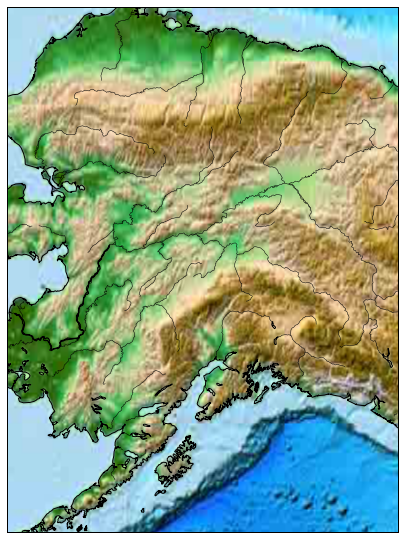

In [4]:
# Let's try out basemap!
ak_bb = [55, 71, -165, -138]

plt.figure(figsize=(7,14))
mp = Basemap(projection="merc",
              lat_0=ak_bb[0], lon_0=ak_bb[2],
              llcrnrlat=ak_bb[0],
              llcrnrlon=ak_bb[2],
              urcrnrlat=ak_bb[1],
              urcrnrlon=ak_bb[3],
              resolution='i')
mp.etopo()
mp.drawmapboundary(fill_color='aqua')
mp.drawrivers()
mp.drawcoastlines()

plt.show()

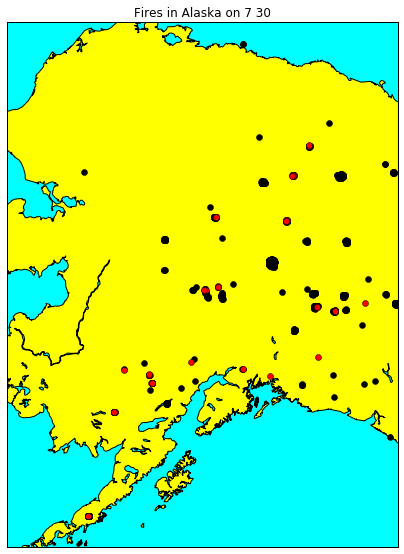

KeyboardInterrupt: 

In [5]:
ak_fires = modis[(modis.lat < 71) & (modis.lat > 55) & (modis.long > -165) & (modis.long < -138)]
ak_summer_fires = ak_fires[(ak_fires.year == 2013) & (ak_fires.month >= 6) & (ak_fires.month <= 8)]

plt.figure(figsize=(7,14))
mp = Basemap(projection="merc",
              lat_0=ak_bb[0], lon_0=ak_bb[2],
              llcrnrlat=ak_bb[0],
              llcrnrlon=ak_bb[2],
              urcrnrlat=ak_bb[1],
              urcrnrlon=ak_bb[3],
              resolution='i')
month = 7
day = 1
prev_lats = []
prev_longs = []
while month < 9:
    todays_fires = ak_fires[(ak_fires.year == 2013) & (ak_fires.month == month) &
                            (ak_fires.day == day)]
    display.clear_output(wait=True)
    plt.figure(figsize=(7,14))
    mp.drawmapboundary(fill_color='aqua')
    mp.fillcontinents(color='yellow',lake_color='aqua')
    mp.drawcoastlines()
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(todays_fires):
        today_longs, today_lats = mp(np.array(todays_fires.long), np.array(todays_fires.lat))
        mp.plot(today_longs, today_lats, 'ro')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    plt.title("Fires in Alaska on %d %d" %(month, day))
    plt.show()
    time.sleep(1)
    day += 1
    if day >= 31 or (day >= 30 and month == 6):
        day = 1
        month += 1

In [ ]:
# Now, let's look at that +/- 5 degrees, and iteratively get closer!
fire_bb = [64.6, 64.9, -147, -146.4]
legend_line = ([64.61, 64.61], [-146.99, -146.98])
mp = Basemap(projection="merc",
              lat_0=float(fire_bb[0]+fire_bb[1])/2, lon_0=float(fire_bb[2]+fire_bb[3])/2,
              llcrnrlat=fire_bb[0],
              llcrnrlon=fire_bb[2],
              urcrnrlat=fire_bb[1],
              urcrnrlon=fire_bb[3],
              resolution='i')
my_fires = modis[(modis.lat < fire_bb[1]) & (modis.lat > fire_bb[0]) &
                 (modis.long < fire_bb[3]) & (modis.long > fire_bb[2])]
month = 6
day = 25
prev_lats = []
prev_longs = []
while month < 8 or day < 12:
    todays_fires = my_fires[(my_fires.year == 2013) & (my_fires.month == month) &
                            (my_fires.day == day)]
    display.clear_output(wait=True)
    plt.figure(figsize=(5,10))
    mp.etopo()
    mp.drawmapboundary(fill_color='aqua')
    #mp.fillcontinents(color='yellow',lake_color='aqua')
    mp.drawcoastlines()
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(todays_fires):
        today_longs, today_lats = mp(np.array(todays_fires.long), np.array(todays_fires.lat))
        mp.plot(today_longs, today_lats, 'ro')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    #legend_line_mp = mp(legend_line[0], legend_line[1])
    #print legend_line_mp
    #mp.plot(legend_line_mp[0], legend_line_mp[1], 'b-')
    plt.title("Fires in 5km BB on %d %d" %(month, day))
    plt.show()
    raw_input("hit enter")
    day += 1
    if day >= 31 or (day >= 30 and month == 6):
        day = 1
        month += 1

Ok, now I'm going to explain what I see in this fire. There's one fire on 6/1, but it doesn't seem to be a part of this fire. This fire actually starts on 6/25, and really takes off on 7/1

another big day 7/8

nothing from 7/9-7/13

another big break from 7/16-8/3

In some areas, we clearly see a lattice pattern in the detections which seems like an artifact of the data collection process. TODO: how far apart are these "lattice points"?

This seems to indicate that it'll be a bit easier to say which pixels are part of the same fire than I originally thought, though this is only one fire, others could be more difficult. Just do some sort of connected component thing.

The fire process seems bursty, some days you get a shitload and some days you don't get any or very few.

This fire was near Fairbanks, and here's an article that references it https://www.adn.com/environment/article/nation-alaska-deals-costly-fire-season/2013/08/29/

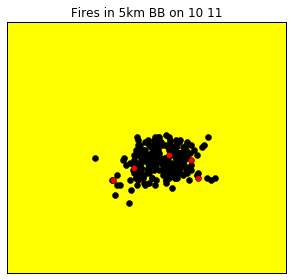

hit enter
236 fires in this region 236 in 2013
fires in this region in 2013 range from 6/14-10/11


In [37]:
# Manually isolate the second fire
fire_2_bb = [56.15, 56.25, -159.5, -159.3]
mp = Basemap(projection="merc",
              lat_0=float(fire_2_bb[0]+fire_2_bb[1])/2, lon_0=float(fire_2_bb[2]+fire_2_bb[3])/2,
              llcrnrlat=fire_2_bb[0],
              llcrnrlon=fire_2_bb[2],
              urcrnrlat=fire_2_bb[1],
              urcrnrlon=fire_2_bb[3])
my_fires_2 = modis[(modis.lat < fire_2_bb[1]) & (modis.lat > fire_2_bb[0]) &
                   (modis.long < fire_2_bb[3]) & (modis.long > fire_2_bb[2])]
month = 6
day = 14
prev_lats = []
prev_longs = []
while month < 10 or day <= 11:
    todays_fires = my_fires_2[(my_fires_2.year == 2013) & (my_fires_2.month == month) &
                            (my_fires_2.day == day)]
    display.clear_output(wait=True)
    plt.figure(figsize=(5,10))
    mp.drawmapboundary(fill_color='aqua')
    mp.fillcontinents(color='yellow',lake_color='aqua')
    mp.drawcoastlines()
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(todays_fires):
        today_longs, today_lats = mp(np.array(todays_fires.long), np.array(todays_fires.lat))
        mp.plot(today_longs, today_lats, 'ro')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    plt.title("Fires in 5km BB on %d %d" %(month, day))
    plt.show()
    raw_input("hit enter")
    day += 1
    if day >= 31 or (day >= 30 and month == 6):
        day = 1
        month += 1
        
my_2013_fires_2 = my_fires_2[my_fires_2.year==2013]
print "%d fires in this region %d in 2013" % (len(my_fires_2), len(my_2013_fires_2))
earliest_month = min(my_2013_fires_2.month)
latest_month = max(my_2013_fires_2.month)
earliest_day = min(my_2013_fires_2[my_2013_fires_2.month == earliest_month].day)
latest_day = max(my_2013_fires_2[my_2013_fires_2.month == latest_month].day)
print "fires in this region in 2013 range from %d/%d-%d/%d" \
        %(earliest_month,earliest_day, latest_month, latest_day)

Finished threshold 0.001000
Finished threshold 0.003000
Finished threshold 0.005000
Finished threshold 0.007000
Finished threshold 0.010000
Finished threshold 0.025000
Finished threshold 0.050000
Finished threshold 0.075000
Finished threshold 0.100000
Finished threshold 0.250000
[34393, 29698, 21924, 14748, 6719, 567, 298, 268, 248, 178]


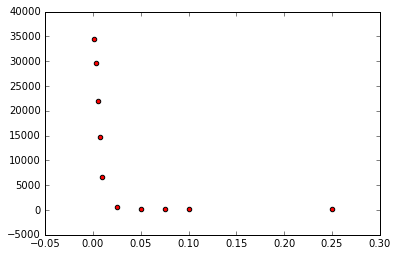

In [11]:
# Try several different cuts, see if there's an obvious cutoff
ak_fires_2013 = ak_fires[ak_fires.year == 2015]
N = len(ak_fires_2013)
threshes = [.001, .003, .005, .007, .01, .025, .05, .075, .1, .25]
n_ccs_list = []
lat_long_mat = np.transpose(np.array((np.array(ak_fires_2013.lat),np.array(ak_fires_2013.long))))
for thresh in threshes:
    thresh_graph = sp.lil_matrix((N,N))
    for i in xrange(N):
        p_i = np.array([ak_fires_2013.iloc[i].lat, ak_fires_2013.iloc[i].long])
        dist_arr = np.linalg.norm(lat_long_mat - p_i, axis=1)
        thresh_arr = dist_arr < thresh
        thresh_graph[i,:] = thresh_arr
    print "Finished threshold %f" %thresh
    n_CCs, CCs = sp.csgraph.connected_components(thresh_graph, directed=False)
    n_ccs_list.append(n_CCs)
print n_ccs_list
plt.close()
plt.scatter(threshes, n_ccs_list, c='r')
plt.show()

In [12]:
deg_thresh = .1
thresh_graph = sp.lil_matrix((N,N))
lat_long_mat = np.transpose(np.array((np.array(ak_fires_2013.lat),np.array(ak_fires_2013.long))))
print "lat_long_mat shape: " + str(lat_long_mat.shape)
for i in xrange(N):
    p_i = np.array([ak_fires_2013.iloc[i].lat, ak_fires_2013.iloc[i].long])
    dist_arr = np.linalg.norm(lat_long_mat - p_i, axis=1)
    thresh_arr = dist_arr < deg_thresh
    thresh_graph[i,:] = thresh_arr
    if i % 1000 == 0:
        print "finished %d of %d" %(i, N)
n_CCs, CCs = sp.csgraph.connected_components(thresh_graph, directed=False)
print "%d connected components" %(n_CCs)

lat_long_mat shape: (34811, 2)
finished 0 of 34811
finished 1000 of 34811
finished 2000 of 34811
finished 3000 of 34811
finished 4000 of 34811
finished 5000 of 34811
finished 6000 of 34811
finished 7000 of 34811
finished 8000 of 34811
finished 9000 of 34811
finished 10000 of 34811
finished 11000 of 34811
finished 12000 of 34811
finished 13000 of 34811
finished 14000 of 34811
finished 15000 of 34811
finished 16000 of 34811
finished 17000 of 34811
finished 18000 of 34811
finished 19000 of 34811
finished 20000 of 34811
finished 21000 of 34811
finished 22000 of 34811
finished 23000 of 34811
finished 24000 of 34811
finished 25000 of 34811
finished 26000 of 34811
finished 27000 of 34811
finished 28000 of 34811
finished 29000 of 34811
finished 30000 of 34811
finished 31000 of 34811
finished 32000 of 34811
finished 33000 of 34811
finished 34000 of 34811
248 connected components


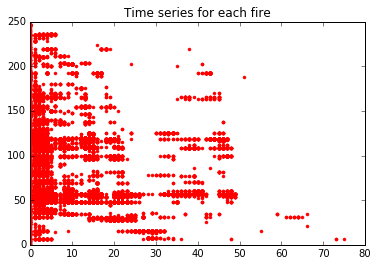

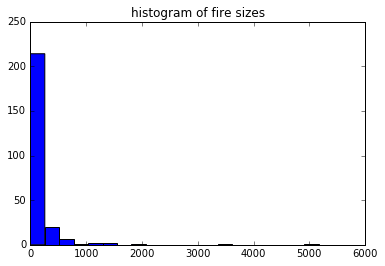

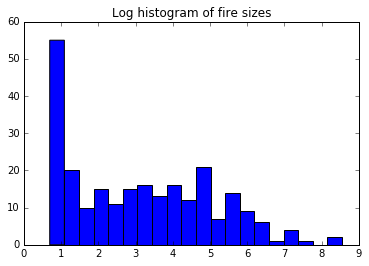

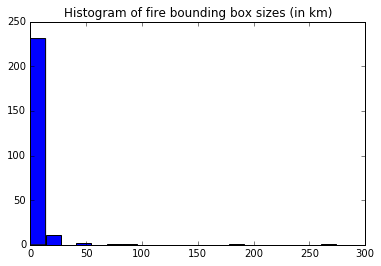

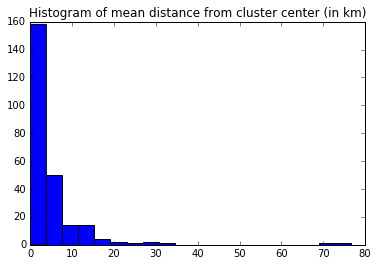

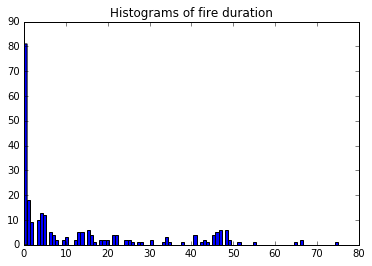

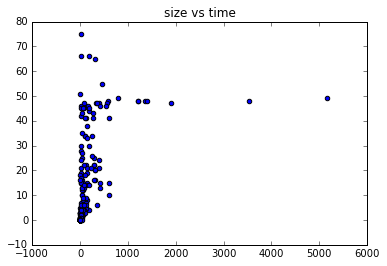

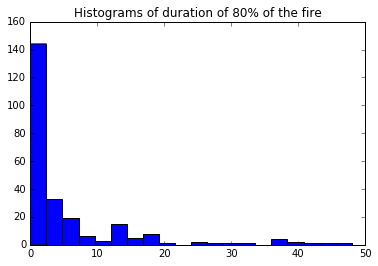

In [14]:
# Let's make some summary stats about the clusters
len_arr = np.zeros(n_CCs)
bb_area_arr = np.zeros(n_CCs)
mean_dist_from_center_arr = np.zeros(n_CCs)
fire_time_arr = np.zeros(n_CCs)
fire_time_80perc_arr = np.zeros(n_CCs)

def monthday2day(month, day, leapyear=False):
    """Convert month/day into days since Jan 1"""
    if leapyear:
        month_arr = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    else:
        month_arr = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days = 0
    for mon in xrange(1, month):
        days += month_arr[mon - 1]
    days += day - 1
    return days
    
for clust in xrange(n_CCs):
    clust_fires = ak_fires_2013.iloc[np.where(CCs == clust)]
    len_arr[clust] = len(clust_fires)
    mean_lat = np.mean(clust_fires.lat)
    mean_long = np.mean(clust_fires.long)
    min_lat = np.inf
    max_lat = -np.inf
    min_long = np.inf
    max_long = -np.inf
    dist_from_center_arr = []
    for lat,lon in zip(clust_fires.lat, clust_fires.long):
        dist_from_center_arr.append(np.sqrt((lat - mean_lat)**2 + (lon - mean_long)**2))
        if lat < min_lat:
            min_lat = lat
        if lat > max_lat:
            max_lat = lat
        if lon < min_long:
            min_long = lon
        if lon > max_long:
            max_long = lon
    bb_area_arr[clust] = (max_lat - min_lat) * (max_long - min_long)
    mean_dist_from_center_arr[clust] = np.mean(dist_from_center_arr)
    
    time_arr = np.zeros(len(clust_fires))
    for i,(month,day) in enumerate(zip(clust_fires.month, clust_fires.day)):
        my_day = monthday2day(month, day, leapyear=False)
        time_arr[i] = my_day
    sorted_times = np.sort(time_arr)
    plt.plot(sorted_times - sorted_times[0], np.zeros(len(sorted_times)) + clust, 'r.')
    max_day = sorted_times[-1]
    min_day = sorted_times[0]
    fire_time_arr[clust] = max_day - min_day
    if len(clust_fires) < 3:
        fire_time_80perc_arr[clust] = max_day - min_day
        continue
    perc20 = int(.2 * len(clust_fires))
    pot_ranges = np.zeros(perc20+1)
    for n_below in xrange(perc20+1):
        n_above = perc20 - n_below
        if n_above == 0:
            this_range = sorted_times[n_below:]
        else:
            this_range = sorted_times[n_below:-(n_above)]
        pot_ranges[n_below] = this_range[-1] - this_range[0]
    fire_time_80perc_arr[clust] = np.min(pot_ranges)

plt.title("Time series for each fire")
plt.show()

plt.hist(len_arr, bins=20)
plt.title("histogram of fire sizes")
plt.show()

plt.hist(np.log(len_arr + 1), bins=20)
plt.title("Log histogram of fire sizes")
plt.show()

plt.hist(bb_area_arr * 111, bins=20)  # convert to km
plt.title("Histogram of fire bounding box sizes (in km)")
plt.show()

plt.hist(mean_dist_from_center_arr * 111, bins=20) # convert to km
plt.title("Histogram of mean distance from cluster center (in km)")
plt.show()

plt.hist(fire_time_arr, bins=100)
plt.title("Histograms of fire duration")
plt.show()

plt.scatter(len_arr, fire_time_arr)
plt.title("size vs time")
plt.show() 

plt.hist(fire_time_80perc_arr, bins=20)
plt.title("Histograms of duration of 80% of the fire")
plt.show()

## Adding temperature and humidity

In [24]:
# Load temp tensor
with open("../data/gfs_temp_2013.pkl") as ftemp:
    temp_tensor = cPickle.load(ftemp)

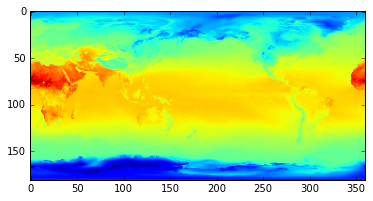

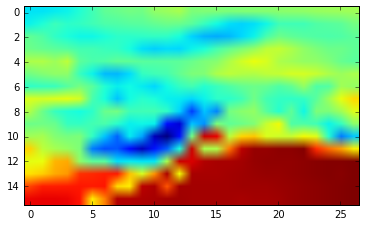

In [25]:
# Make sure we can plot temp_tensor properly
ak_bb = [90-55, 90-71, -165, -138]
plt.imshow(temp_tensor[:,:,100])
plt.show()
plt.imshow(temp_tensor[ak_bb[1]:ak_bb[0], ak_bb[2]:ak_bb[3], 100])
plt.show()

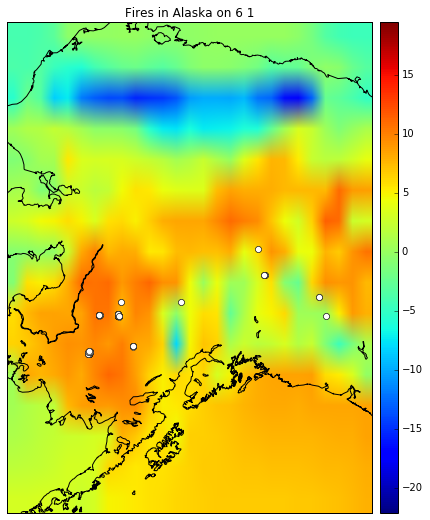

In [41]:
# Plot AK fires over time with temperature overlayed
ak_bb = [55, 71, -165, -138]
ak_bb_plotter = [90-55, 90-71, -165, -138]
ak_fires = modis[(modis.lat < ak_bb[1]) & (modis.lat > ak_bb[0]) &
                 (modis.long < ak_bb[3]) & (modis.long > ak_bb[2])]
summer_beg = monthday2day(6,1)
summer_end = monthday2day(9,1)
min_temp = np.min(temp_tensor[(89-55):(89-71):-1, -165:-138, summer_beg:summer_end]) - 273
max_temp = np.max(temp_tensor[(89-55):(89-71):-1, -165:-138, summer_beg:summer_end]) - 273
print "min_temp/max_temp: " + str((min_temp,max_temp))
month = 6
day = 1
prev_lats = []
prev_longs = []
while month < 9:
    todays_fires = ak_fires[(ak_fires.year == 2013) & (ak_fires.month == month) &
                            (ak_fires.day == day)]
    day_in_year = monthday2day(month, day, leapyear=False)
    display.clear_output(wait=True)
    plt.figure(figsize=(7,14))
    plt.plot
    mp = Basemap(projection="merc",
              lat_0=55, lon_0=-165,
              llcrnrlat=55,
              llcrnrlon=-165,
              urcrnrlat=71,
              urcrnrlon=-138,
              resolution='i')
    mp.drawcoastlines()
    mp.imshow(temp_tensor[(89-55):(89-71):-1, -165:-138, day_in_year] - 273,    
              vmin=min_temp, vmax=max_temp)
    mp.colorbar()
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(todays_fires):
        today_longs, today_lats = mp(np.array(todays_fires.long), np.array(todays_fires.lat))
        mp.plot(today_longs, today_lats, 'wo')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    plt.title("Fires in Alaska on %d %d" %(month, day))
    plt.show()
    break
    #time.sleep(1)
    day += 1
    if day >= 31 or (day >= 30 and month == 6):
        day = 1
        month += 1

86 nans


/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


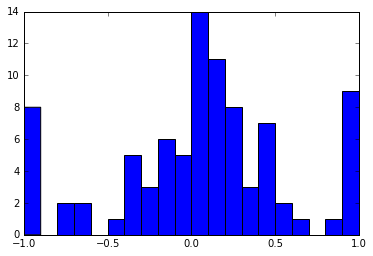

mean correlation: 0.0606967341049
number above 0: 56, number below 0: 32


/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


In [27]:
# Now, let's look at the correlation between fire frequency and temperature
corrs = np.zeros(n_CCs)
for clust in xrange(n_CCs):
    clust_fires = ak_fires_2013.iloc[np.where(CCs == clust)]
    mean_lat_int = int(np.mean(clust_fires.lat))
    mean_long_int = int(np.mean(clust_fires.long))
    time_arr = np.zeros(len(clust_fires))
    for i,(month,day) in enumerate(zip(clust_fires.month, clust_fires.day)):
        my_day = monthday2day(month, day, leapyear=False)
        time_arr[i] = my_day
    max_day = int(np.max(time_arr))
    min_day = int(np.min(time_arr))
    fire_time_series = np.zeros(max_day-min_day+1)
    weather_time_series = np.zeros(max_day-min_day+1)
    for i,day in enumerate(xrange(min_day, max_day+1)):
        fire_time_series[i] = np.sum(time_arr == day)
        weather_time_series[i] = temp_tensor[90-mean_lat_int, mean_long_int, day]
    corrs[clust] = pearsonr(fire_time_series, weather_time_series)[0]
nans = np.isnan(corrs)
print "%d nans" % np.sum(nans)
plt.hist(corrs[True - nans], bins=20)
plt.show()
print "mean correlation: " + str(np.mean(corrs[True-nans]))
print "number above 0: %d, number below 0: %d" % (np.sum(corrs > 0), np.sum(corrs < 0))

In [28]:
# Humidity
# Load temp tensor
with open("../data/hum_2013.pkl") as ftemp:
    hum_tensor = cPickle.load(ftemp)

IOError: [Errno 2] No such file or directory: '../data/hum_2013.pkl'

In [29]:
# Make sure we can plot temp_tensor properly
ak_bb = [90-55, 90-71, -165, -138]
plt.imshow(hum_tensor[:,:,100])
plt.show()
plt.imshow(hum_tensor[ak_bb[1]:ak_bb[0], ak_bb[2]:ak_bb[3], 100])
plt.show()

NameError: name 'hum_tensor' is not defined

In [30]:
# Plot AK fires over time with humidities overlayed
ak_bb = [55, 71, -165, -138]
ak_bb_plotter = [90-55, 90-71, -165, -138]
ak_fires = modis[(modis.lat < ak_bb[1]) & (modis.lat > ak_bb[0]) &
                 (modis.long < ak_bb[3]) & (modis.long > ak_bb[2])]
summer_beg = monthday2day(6,1)
summer_end = monthday2day(9,1)
min_hum = np.min(hum_tensor[(89-55):(89-71):-1, -165:-138, summer_beg:summer_end]) - 273
max_hum = np.max(hum_tensor[(89-55):(89-71):-1, -165:-138, summer_beg:summer_end]) - 273
print "min_hum/max_hum: " + str((min_hum,max_hum))
month = 6
day = 1
prev_lats = []
prev_longs = []
while month < 9:
    todays_fires = ak_fires[(ak_fires.year == 2013) & (ak_fires.month == month) &
                            (ak_fires.day == day)]
    day_in_year = monthday2day(month, day, leapyear=False)
    display.clear_output(wait=True)
    plt.figure(figsize=(7,14))
    plt.plot
    mp = Basemap(projection="merc",
              lat_0=55, lon_0=-165,
              llcrnrlat=55,
              llcrnrlon=-165,
              urcrnrlat=71,
              urcrnrlon=-138,
              resolution='i')
    mp.drawcoastlines()
    mp.imshow(hum_tensor[(89-55):(89-71):-1, -165:-138, day_in_year] - 273,    
              vmin=min_hum, vmax=max_hum)
    mp.colorbar()
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(todays_fires):
        today_longs, today_lats = mp(np.array(todays_fires.long), np.array(todays_fires.lat))
        mp.plot(today_longs, today_lats, 'wo')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    plt.title("Fires in Alaska on %d %d" %(month, day))
    plt.show()
    #time.sleep(1)
    day += 1
    if day >= 31 or (day >= 30 and month == 6):
        day = 1
        month += 1

NameError: name 'hum_tensor' is not defined

In [ ]:
# Now, let's look at the correlation between fire frequency and humidity
corrs = np.zeros(n_CCs)
for clust in xrange(n_CCs):
    clust_fires = ak_fires_2013.iloc[np.where(CCs == clust)]
    mean_lat_int = int(np.mean(clust_fires.lat))
    mean_long_int = int(np.mean(clust_fires.long))
    time_arr = np.zeros(len(clust_fires))
    for i,(month,day) in enumerate(zip(clust_fires.month, clust_fires.day)):
        my_day = monthday2day(month, day, leapyear=False)
        time_arr[i] = my_day
    max_day = int(np.max(time_arr))
    min_day = int(np.min(time_arr))
    fire_time_series = np.zeros(max_day-min_day+1)
    weather_time_series = np.zeros(max_day-min_day+1)
    for i,day in enumerate(xrange(min_day, max_day+1)):
        fire_time_series[i] = np.sum(time_arr == day)
        weather_time_series[i] = hum_tensor[90-mean_lat_int, mean_long_int, day]
    corrs[clust] = pearsonr(fire_time_series, weather_time_series)[0]
nans = np.isnan(corrs)
print "%d nans" % np.sum(nans)
plt.hist(corrs[True - nans], bins=20)
plt.show()
print "mean correlation: " + str(np.mean(corrs[True-nans]))
print "number above 0: %d, number below 0: %d" % (np.sum(corrs > 0), np.sum(corrs < 0))